In [22]:
#load the necessary modules
import pandas as pd
import numpy as np
import datetime, math
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, classification_report
from sklearn import svm, preprocessing
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical

from keras.utils.vis_utils import plot_model

In [23]:
# loaded the csv file
df_train = pd.read_csv("../ten-datasets/pointcloudmnist2d/train.csv")
df_test = pd.read_csv("../ten-datasets/pointcloudmnist2d/test.csv")
df_train.head()

,label,x0,y0,v0,x1,y1,v1,x2,y2,v2,...,v347,x348,y348,v348,x349,y349,v349,x350,y350,v350
0,5,17,10,249,16,6,81,13,14,241,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,0,22,17,50,8,8,225,22,15,195,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,4,8,12,207,10,11,98,19,20,2,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,1,8,6,48,11,8,251,14,13,251,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,9,17,15,253,16,4,56,9,14,176,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [24]:
df_test.head()

,label,x0,y0,v0,x1,y1,v1,x2,y2,v2,...,v347,x348,y348,v348,x349,y349,v349,x350,y350,v350
0,7,14,7,254,21,18,140,21,17,106,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2,17,6,253,16,19,253,10,7,253,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,1,16,18,223,10,4,5,15,13,165,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,0,17,8,253,20,17,105,14,20,251,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,4,18,17,18,10,11,85,17,4,236,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [25]:
X_train = np.array(df_train.loc[:, 'x0':'v350'])
y_train = np.array(df_train['label'])
X_train.shape

(60000, 1053)

In [26]:
X_test = np.array(df_test.loc[:, 'x0':'v350'])
y_test = np.array(df_test['label'])
X_test.shape

(10000, 1053)

In [27]:
y_train = y_train.reshape(-1, 1)
y_train.shape

(60000, 1)

In [28]:
y_test = y_test.reshape(-1, 1)
y_test.shape

(10000, 1)

/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


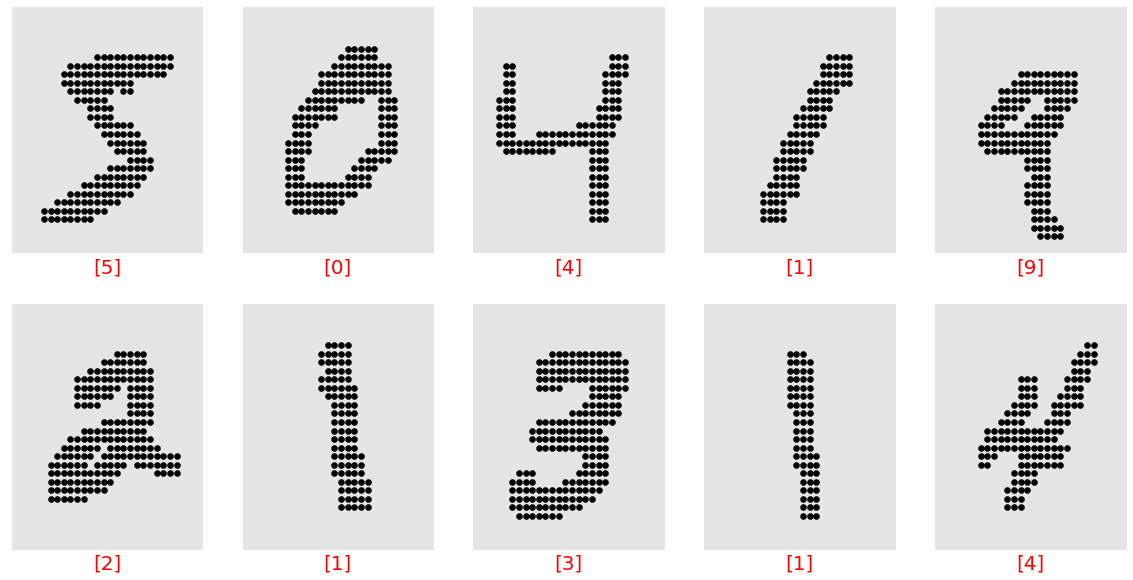

In [29]:
#visualize the first 10 training images 
i, x, y = 0, 0, 0

plt.figure(figsize=(20,10))
for num_fig in range(10):
    plt.subplot(2, 5, num_fig+1)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(-1, 28)
    plt.ylim(-1, 28)
    plt.xlabel(y_train[num_fig], size=20, color='red')
    i = 0
    for val in X_train[num_fig]:
        if val != -1:
            if i % 3 == 0:
                x = val
            if i % 3 == 1:
                y = val
            if i % 3 == 2:
                plt.scatter(x, y, color='black')
                #print(i)
        #print(val)
       
        i += 1



In [30]:
def restore_image_array(X_array, resolution):
    num_samples = len(X_array)
    #print(num_samples)
    X_img = np.zeros((num_samples, resolution, resolution))
    
    x, y, pixel = 0, 0, 0
    
    for seq in range(num_samples):
        i = 0
        for val in X_array[seq]:
            if val != -1:
                if i % 3 == 0:
                    x = val
                if i % 3 == 1:
                    y = val
                if i % 3 == 2:
                    pixel = val
                    X_img[seq][27-y][x] = pixel
                 
            i += 1
    
    return X_img
    

In [31]:
X_img_train = restore_image_array(X_train, 28)
X_img_train.shape

(60000, 28, 28)

In [32]:
X_img_test = restore_image_array(X_test, 28)
X_img_test.shape

(10000, 28, 28)

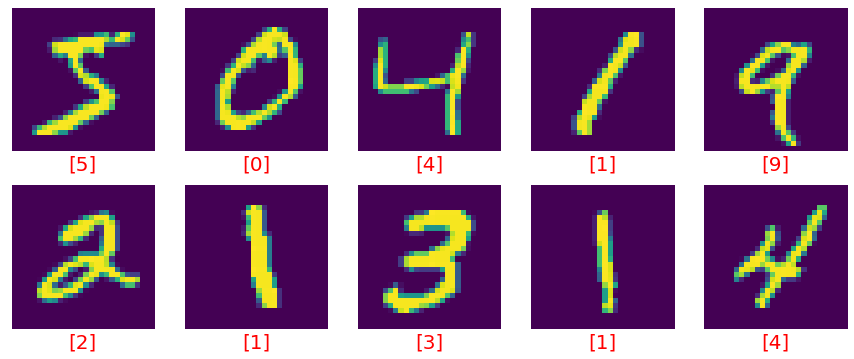

In [33]:
#visualize the first 10 image after restore as image format
plt.figure(figsize=(15,6))
for num_fig in range(10):
    plt.subplot(2, 5, num_fig+1)
    plt.imshow(X_img_train[num_fig])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(y_train[num_fig], size=20, color='red')


# Shallow Learning

# K-nearest neighbors

In [34]:
X_img_train.shape

(60000, 28, 28)

In [35]:
# reduce the dim of the array
X_flatten_train = X_img_train.reshape(len(X_img_train), -1)
X_flatten_test = X_img_test.reshape(len(X_img_test), -1)
print(X_flatten_train.shape)
print(X_flatten_test.shape)

(60000, 784)
(10000, 784)


In [36]:
def model_fit_report(y_values_actual, y_values_predicted, labels):
       
        
    matrix = confusion_matrix(y_values_actual, y_values_predicted, labels)#labels=lb.classes_
    fig, ax = plt.subplots(figsize=(14, 12))
    sns.heatmap(matrix, annot=True, fmt='d', linewidths=.5, center=0)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.xticks(np.arange(len(labels))+0.5, labels)
    plt.ylabel('True label')
    plt.yticks(np.arange(len(labels))+0.5, labels)
    plt.show()

    print("Classification Report")
    print("")
    print (classification_report(y_values_actual, y_values_predicted))

In [16]:
%%time

clf = KNeighborsClassifier()
clf.fit(X_flatten_train, y_train)

/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


CPU times: user 1min 22s, sys: 2.56 s, total: 1min 24s
Wall time: 2min 25s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [17]:
# %%time

# accuracy = clf.score(X_flatten_train, y_train)
#print('model training accuracy: %.4f' %(accuracy))

In [18]:
%%time

accuracy = clf.score(X_flatten_test, y_test)
print('model test accuracy: %.4f' %(accuracy))
#accuracy

model test accuracy: 0.9688
CPU times: user 17min, sys: 14.5 s, total: 17min 14s
Wall time: 29min 55s


# Extra trees

In [19]:
%%time

clf = ExtraTreesClassifier(n_estimators=100, max_features='sqrt', random_state=0)
clf.fit(X_flatten_train, y_train)

/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


CPU times: user 1min 15s, sys: 1.9 s, total: 1min 17s
Wall time: 1min 56s


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

In [20]:
accuracy = clf.score(X_flatten_train, y_train)
print('model training accuracy: ',accuracy)

model training accuracy:  1.0


In [21]:
accuracy = clf.score(X_flatten_test, y_test)
print('model test accuracy: ',accuracy)

model test accuracy:  0.9706


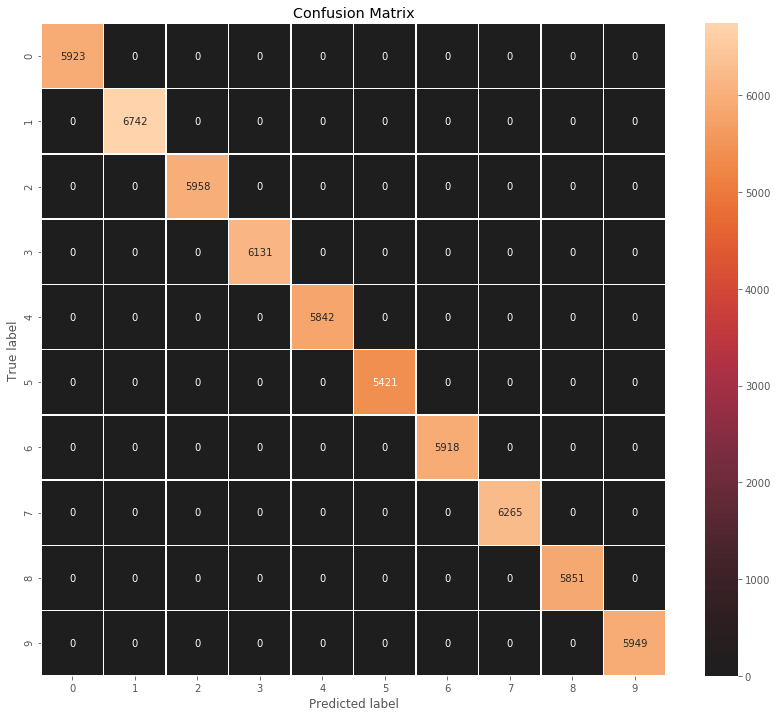

Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5923
           1       1.00      1.00      1.00      6742
           2       1.00      1.00      1.00      5958
           3       1.00      1.00      1.00      6131
           4       1.00      1.00      1.00      5842
           5       1.00      1.00      1.00      5421
           6       1.00      1.00      1.00      5918
           7       1.00      1.00      1.00      6265
           8       1.00      1.00      1.00      5851
           9       1.00      1.00      1.00      5949

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



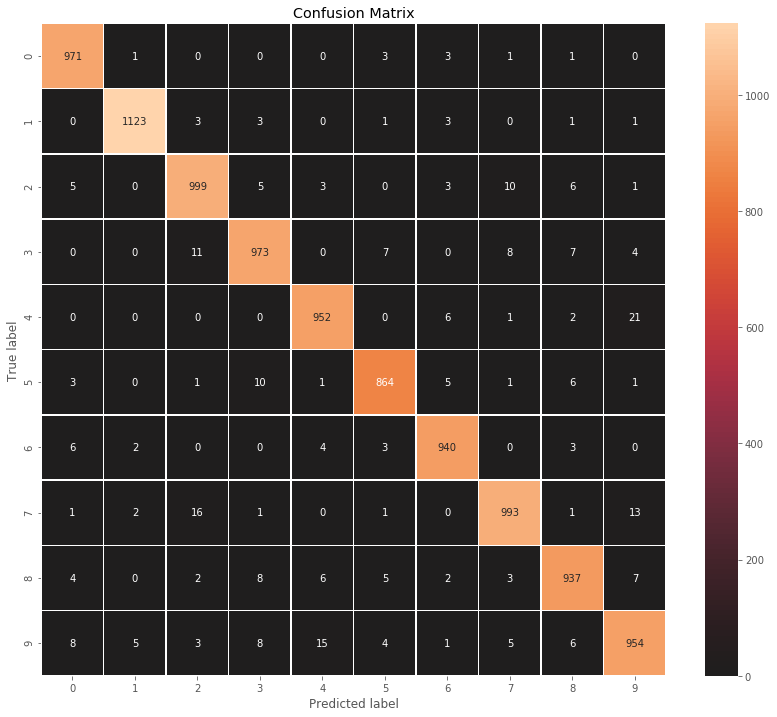

Classification Report

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.96      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [22]:
y_train_predict = clf.predict(X_flatten_train)
model_fit_report(y_train, y_train_predict, np.unique(y_train))

#get results for test dataset
y_test_predict = clf.predict(X_flatten_test)
model_fit_report(y_test, y_test_predict, np.unique(y_test))

# Random Forest

In [23]:
%%time

clf = RandomForestClassifier(criterion='gini', n_estimators=100)
clf.fit(X_flatten_train, y_train)


/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


CPU times: user 1min 12s, sys: 2.14 s, total: 1min 15s
Wall time: 1min 50s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
accuracy = clf.score(X_flatten_train, y_train)
print('model training accuracy: %.4f' %(accuracy))

model training accuracy: 1.0000


In [25]:
accuracy = clf.score(X_flatten_test, y_test)
print('model test accuracy: %.4f' %(accuracy))

model test accuracy: 0.9693


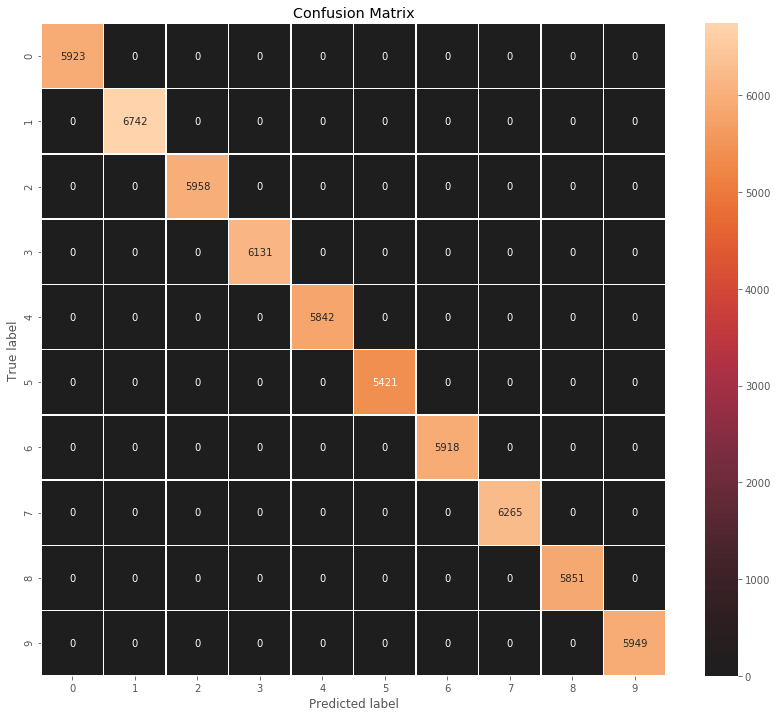

Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5923
           1       1.00      1.00      1.00      6742
           2       1.00      1.00      1.00      5958
           3       1.00      1.00      1.00      6131
           4       1.00      1.00      1.00      5842
           5       1.00      1.00      1.00      5421
           6       1.00      1.00      1.00      5918
           7       1.00      1.00      1.00      6265
           8       1.00      1.00      1.00      5851
           9       1.00      1.00      1.00      5949

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



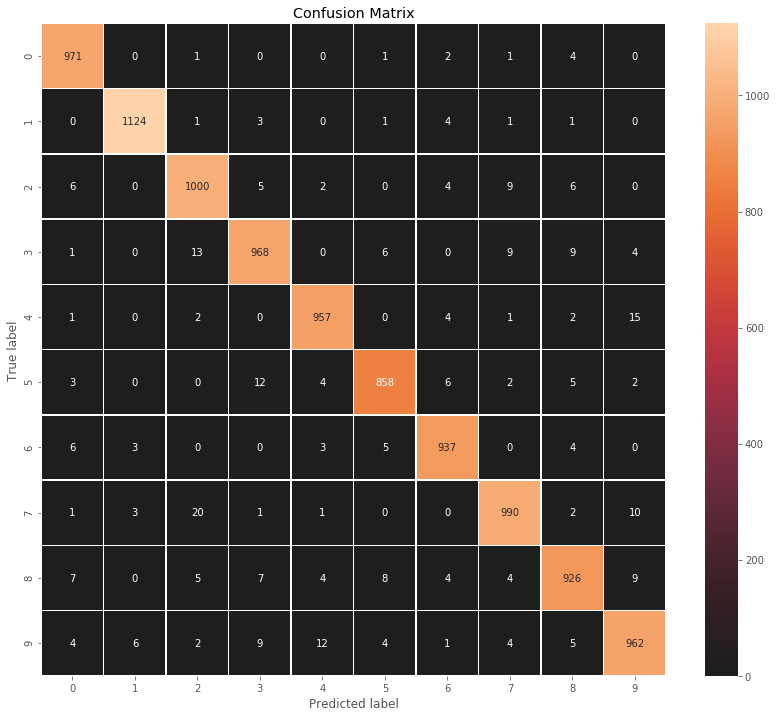

Classification Report

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [26]:
y_train_predict = clf.predict(X_flatten_train)
model_fit_report(y_train, y_train_predict, np.unique(y_train))

#get results for test dataset
y_test_predict = clf.predict(X_flatten_test)
model_fit_report(y_test, y_test_predict, np.unique(y_test))

# Deep Learning

In [37]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Conv1D, Conv2D, BatchNormalization, Activation, MaxPooling1D, MaxPooling2D, Dropout, Flatten, Dense, LSTM

In [38]:
num_classes = 10

In [39]:
X_flatten_train.shape[1:]

(784,)

In [40]:
# Scale value to range 0 to 1 
X_flatten_train = X_flatten_train / 255.0
X_flatten_test = X_flatten_test / 255.0

In [41]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
y_train_cat.shape

(60000, 10)

In [42]:
def plot_history(history):
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')

    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Artificial neural network

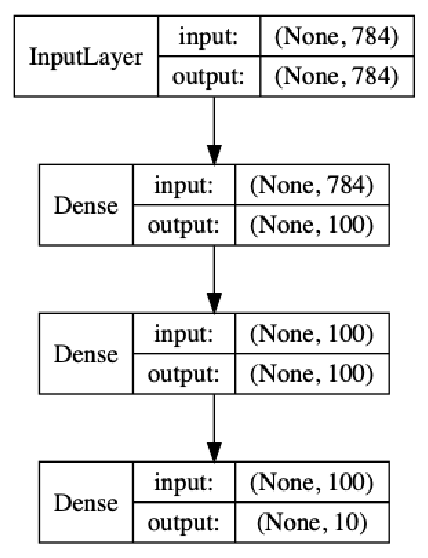

In [36]:
# 2 hidden layers, 100 units
inputs = Input(shape=X_flatten_train.shape[1:])
hidden = Dense(100, activation='relu')(inputs)
Dropout(0.25)
hidden = Dense(100, activation='relu')(hidden)
Dropout(0.25)
preds = Dense(num_classes,activation='softmax')(hidden)

model = Model(inputs=inputs,outputs=preds)


image_name = 'mnist_ann_model.png'
plot_model(model,to_file=image_name,show_shapes=True,show_layer_names=False,rankdir='TB')
plt.figure(figsize=(10,10))
img = plt.imread(image_name)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
#model.compile(optimizer='sgd' ,loss='mse',metrics=['accuracy'])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_flatten_train, y_train, batch_size=128, epochs=10, validation_data=(X_flatten_test, y_test))

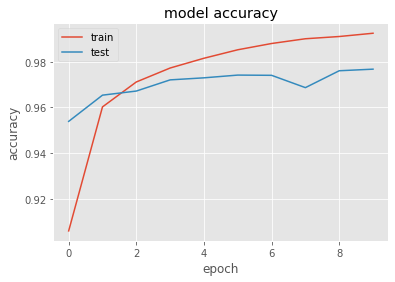

In [55]:
plot_history(history)

In [56]:
model.compile(optimizer='sgd' ,loss='mse',metrics=['accuracy'])

history = model.fit(X_flatten_train, y_train_cat, batch_size=128, epochs=10, validation_data=(X_flatten_test, y_test_cat))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 31us/step - loss: 6.7989e-04 - accuracy: 0.9959 - val_loss: 0.0035 - val_accuracy: 0.9771
Epoch 2/10
60000/60000 [==============================] - 2s 27us/step - loss: 6.2351e-04 - accuracy: 0.9964 - val_loss: 0.0035 - val_accuracy: 0.9779
Epoch 3/10
60000/60000 [==============================] - 2s 29us/step - loss: 5.8674e-04 - accuracy: 0.9966 - val_loss: 0.0034 - val_accuracy: 0.9783
Epoch 4/10
60000/60000 [==============================] - 2s 28us/step - loss: 5.6068e-04 - accuracy: 0.9968 - val_loss: 0.0034 - val_accuracy: 0.9788
Epoch 5/10
60000/60000 [==============================] - 2s 29us/step - loss: 5.4094e-04 - accuracy: 0.9969 - val_loss: 0.0034 - val_accuracy: 0.9789
Epoch 6/10
60000/60000 [==============================] - 2s 27us/step - loss: 5.2521e-04 - accuracy: 0.9970 - val_loss: 0.0033 - val_accuracy: 0.9787
Epoch 7/10
60000/60000 [====================

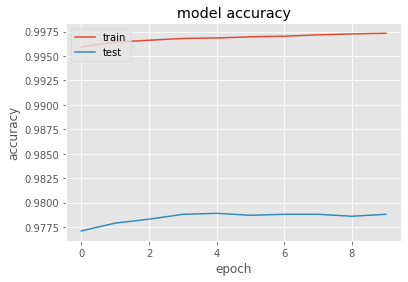

In [57]:
plot_history(history)

In [41]:
# 2 hidden layers, 100 units
inputs = Input(shape=X_flatten_train.shape[1:])
hidden = Dense(300, activation='relu')(inputs)
Dropout(0.25)
hidden = Dense(300, activation='relu')(hidden)
Dropout(0.25)
preds = Dense(num_classes,activation='softmax')(hidden)

model = Model(inputs=inputs,outputs=preds)

In [42]:
#model.compile(optimizer='sgd' ,loss='mse',metrics=['accuracy'])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_flatten_train, y_train, batch_size=128, epochs=10, validation_data=(X_flatten_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 58us/step - loss: 0.2551 - accuracy: 0.9253 - val_loss: 0.1140 - val_accuracy: 0.9653
Epoch 2/10
60000/60000 [==============================] - 3s 55us/step - loss: 0.0929 - accuracy: 0.9725 - val_loss: 0.0851 - val_accuracy: 0.9715
Epoch 3/10
60000/60000 [==============================] - 3s 55us/step - loss: 0.0605 - accuracy: 0.9815 - val_loss: 0.0778 - val_accuracy: 0.9753
Epoch 4/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.0435 - accuracy: 0.9864 - val_loss: 0.0696 - val_accuracy: 0.9797
Epoch 5/10
60000/60000 [==============================] - 3s 55us/step - loss: 0.0326 - accuracy: 0.9897 - val_loss: 0.0687 - val_accuracy: 0.9792
Epoch 6/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.0248 - accuracy: 0.9918 - val_loss: 0.0789 - val_accuracy: 0.9772
Epoch 7/10
60000/60000 [==============================] - 3s 56us/st

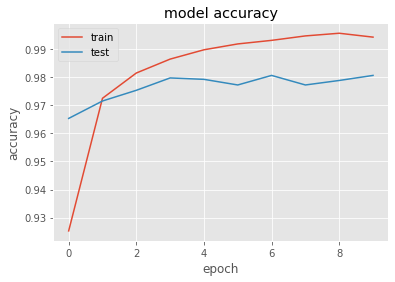

In [43]:
plot_history(history)

In [44]:
# 2 hidden layers, 100 units
inputs = Input(shape=X_flatten_train.shape[1:])
hidden = Dense(512, activation='relu')(inputs)
Dropout(0.25)
hidden = Dense(512, activation='relu')(hidden)
Dropout(0.25)
preds = Dense(num_classes,activation='softmax')(hidden)

model = Model(inputs=inputs,outputs=preds)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_flatten_train, y_train, batch_size=128, epochs=10, validation_data=(X_flatten_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.2189 - accuracy: 0.9353 - val_loss: 0.0962 - val_accuracy: 0.9695
Epoch 2/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.0787 - accuracy: 0.9765 - val_loss: 0.0884 - val_accuracy: 0.9721
Epoch 3/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.0496 - accuracy: 0.9842 - val_loss: 0.0730 - val_accuracy: 0.9777
Epoch 4/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.0368 - accuracy: 0.9883 - val_loss: 0.0710 - val_accuracy: 0.9791
Epoch 5/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.0285 - accuracy: 0.9905 - val_loss: 0.0848 - val_accuracy: 0.9758
Epoch 6/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.0208 - accuracy: 0.9933 - val_loss: 0.0762 - val_accuracy: 0.9800
Epoch 7/10
60000/60000 [==============================] - 8s 1

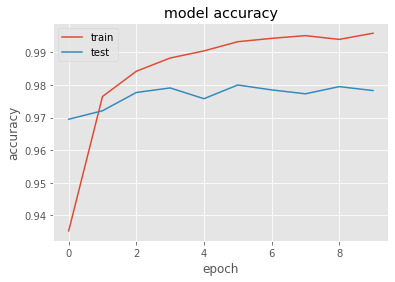

In [45]:
plot_history(history)

# CNN

In [43]:
# Scale value to range 0 to 1 
X_img_train = X_img_train / 255.0
X_img_test = X_img_test / 255.0

In [44]:
X_img_train = X_img_train[:, :, :, np.newaxis]
X_img_train.shape

(60000, 28, 28, 1)

In [45]:
X_img_test = X_img_test[:, :, :, np.newaxis]
X_img_test.shape

(10000, 28, 28, 1)

Instructions for updating:
Colocations handled automatically by placer.


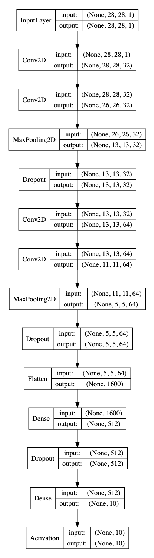

In [46]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_img_train.shape[1:]))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

image_name = 'mnist_cnn_model.png'
plot_model(model,to_file=image_name,show_shapes=True,show_layer_names=False,rankdir='TB')
plt.figure(figsize=(10,10))
img = plt.imread(image_name)
plt.imshow(img)
plt.axis('off')
plt.show()

In [47]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)         

In [48]:
history = model.fit(X_img_train, y_train, batch_size=128, epochs=10, validation_data=(X_img_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 159s 3ms/step - loss: 0.2091 - accuracy: 0.9344 - val_loss: 0.0378 - val_accuracy: 0.9873
Epoch 2/10
60000/60000 [==============================] - 150s 2ms/step - loss: 0.0630 - accuracy: 0.9812 - val_loss: 0.0303 - val_accuracy: 0.9912
Epoch 3/10
60000/60000 [==============================] - 149s 2ms/step - loss: 0.0479 - accuracy: 0.9860 - val_loss: 0.0255 - val_accuracy: 0.9912
Epoch 4/10
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0371 - accuracy: 0.9887 - val_loss: 0.0227 - val_accuracy: 0.9928
Epoch 5/10
60000/60000 [==============================] - 146s 2ms/step - loss: 0.0330 - accuracy: 0.9900 - val_loss: 0.0214 - val_accuracy: 0.9932
Epoch 6/10
60000/60000 [==============================] - 147s 2ms/step - loss: 0.0286 - accuracy: 0.9907 - val_loss: 0.0243 - val_accuracy: 0.9923
Epoch 7/10
60000/60000 [==============================] - 146s

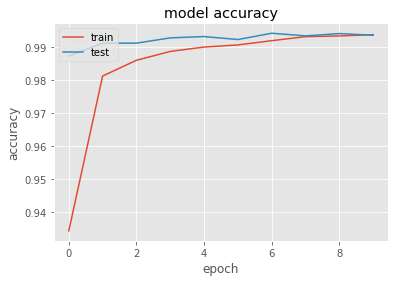

In [49]:
plot_history(history)

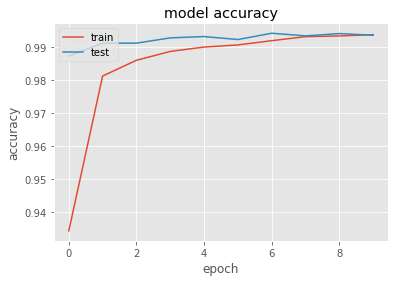

In [51]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

image_name = 'mnist_cnn_accuracy.png'
plt.savefig(image_name)

plt.show()

# LSTM

In [ ]:
lstm_units = 200
BATCH_SIZE = 64

model = Sequential() 
model.add(LSTM(units = lstm_units,input_shape = (28, 28), dropout=0.25, return_sequences=True)) # 3D tensor with shape (batch_size, timesteps, input_dim).
model.add(LSTM(units = lstm_units, dropout=0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

model.summary()

image_name = 'plusarStars_lstm_model.png'
plot_model(model,to_file=image_name,show_shapes=True,show_layer_names=False,rankdir='TB')
plt.figure(figsize=(10,10))
img = plt.imread(image_name)
plt.imshow(img)
plt.axis('off')
plt.show()

In [47]:
history = model.fit(X_img_train, y_train, batch_size=128 ,epochs=10, validation_data=(X_img_test, y_test))

ValueError: Error when checking input: expected lstm_3_input to have 3 dimensions, but got array with shape (60000, 28, 28, 1)

In [ ]:
plot_history(history)